# ML 1 Project - Hand Gesture Classification

## Data Exploration, Preprocessing, and Visualization

### 1. Data Exploration

In [3]:
from MLflow_helper import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# Create an MLflow experiment to document our results

create_experiment('Hand Gesture Classification')

2026/02/23 00:18:13 INFO mlflow.tracking.fluent: Experiment with name 'Hand Gesture Classification' does not exist. Creating a new experiment.


In [5]:
data = pd.read_csv('./hand_landmarks_data.csv')

data.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [6]:
# Let's get some insights about our dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [7]:
# Let's get the percentage of each gesture in the data

gesture_percentages = (data['label'].value_counts() / len(data)) * 100
gesture_percentages

label
three2             6.438169
palm               6.422590
four               6.364167
ok                 6.200584
stop_inverted      6.103213
call               5.865628
peace_inverted     5.830574
stop               5.772152
rock               5.678676
three              5.670886
peace              5.612463
like               5.592989
two_up_inverted    5.339825
two_up             5.230769
dislike            5.043817
one                4.919182
mute               4.233690
fist               3.680623
Name: count, dtype: float64

The class percentages are nearly similar. The most dominant gesture is **three2** and the least dominant is **fist**.

In [8]:
# Check if there are missing values

missing_flag = False
for col in data.columns:
    if data[col].isna().sum() != 0:
        missing_flag = True
        print(f'The column {col} has missing values.')

if missing_flag == False:
    print('There are no missing values in the data.')

There are no missing values in the data.


In [9]:
# Check if there are duplicates in the data

data[data.duplicated()]

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label


The dataset contains no missing values and no duplicate rows.

### 2. Data Preprocessing

In [10]:
# 1 - recenter the landmarks (x, y) to make the origin the wrist point
# 2 - divide all the landmarks by the mid-finger tip position
# NOTE: z location doesn’t need to be processed as it is already processed

def preprocess_landmarks(landmarks):
    """
    Recenters landmarks to the wrist (0) and scales by the middle finger tip (12).
    """
    
    # Extract x and y coordinates (assuming columns are named x0, y0, z0, x1, y1, z1...)
    x_cols = [f'x{i}' for i in range(1, 22)]
    y_cols = [f'y{i}' for i in range(1, 22)]
    
    x_coords = landmarks[x_cols].values.astype(float)
    y_coords = landmarks[y_cols].values.astype(float)
    
    # Recenter: Make the wrist (index 0) the origin (0,0)
    x_wrist, y_wrist = x_coords[:, 0].reshape(-1, 1), y_coords[:, 0].reshape(-1, 1)
    x_centered = x_coords - x_wrist
    y_centered = y_coords - y_wrist
    
    # Scale: Divide by the middle finger tip (index 12) position
    scale_factor = np.sqrt(x_centered[:, 12]**2 + y_centered[:, 12]**2).reshape(-1, 1)
    
    # Avoid division by zero if landmark 12 is at the origin
    # if scale_factor != 0:
    #     x_scaled = x_centered / scale_factor
    #     y_scaled = y_centered / scale_factor
    # else:
    #     x_scaled, y_scaled = x_centered, y_centered
    x_scaled = x_centered / scale_factor
    y_scaled = y_centered / scale_factor

    landmarks[x_cols] = x_scaled
    landmarks[y_cols] = y_scaled
        
    return landmarks

In [11]:
# Apply the preprocessing to the data

preprocessed_data =  preprocess_landmarks(data)

### 3. Data Visualization

In [12]:
def plot_gestures(data, labels, rows, cols, figsize):
    x_cols = [f'x{i}' for i in range(1, 22)]
    y_cols = [f'y{i}' for i in range(1, 22)]

    xs = data[x_cols].values
    ys = data[y_cols].values

    gesture_index = 0
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for row in range(rows):
        for col in range(cols):
            # Plot the gesture landmarks
            axes[row, col].scatter(xs[gesture_index], -ys[gesture_index], color='tab:red')

            # Plot the connections
            connections = connections = [
                (0,1), (1,2), (2,3), (3,4),         # Thumb
                (0,5), (5,6), (6,7), (7,8),         # Index
                (9,10), (10,11), (11,12),           # Middle
                (13,14), (14,15), (15,16),          # Ring
                (0,17), (17,18), (18,19), (19,20),  # Pinky
                (5,9), (9,13), (13,17)              # Palm
            ]

            for start, end in connections:
                axes[row, col].plot([xs[gesture_index, start], xs[gesture_index, end]],
                                    [-ys[gesture_index, start], -ys[gesture_index, end]], color='tab:blue')
            
            axes[row, col].set_title(f'{labels.iloc[gesture_index]}')
            gesture_index += 1

    fig.suptitle('Sample of Gestures')
    plt.tight_layout()

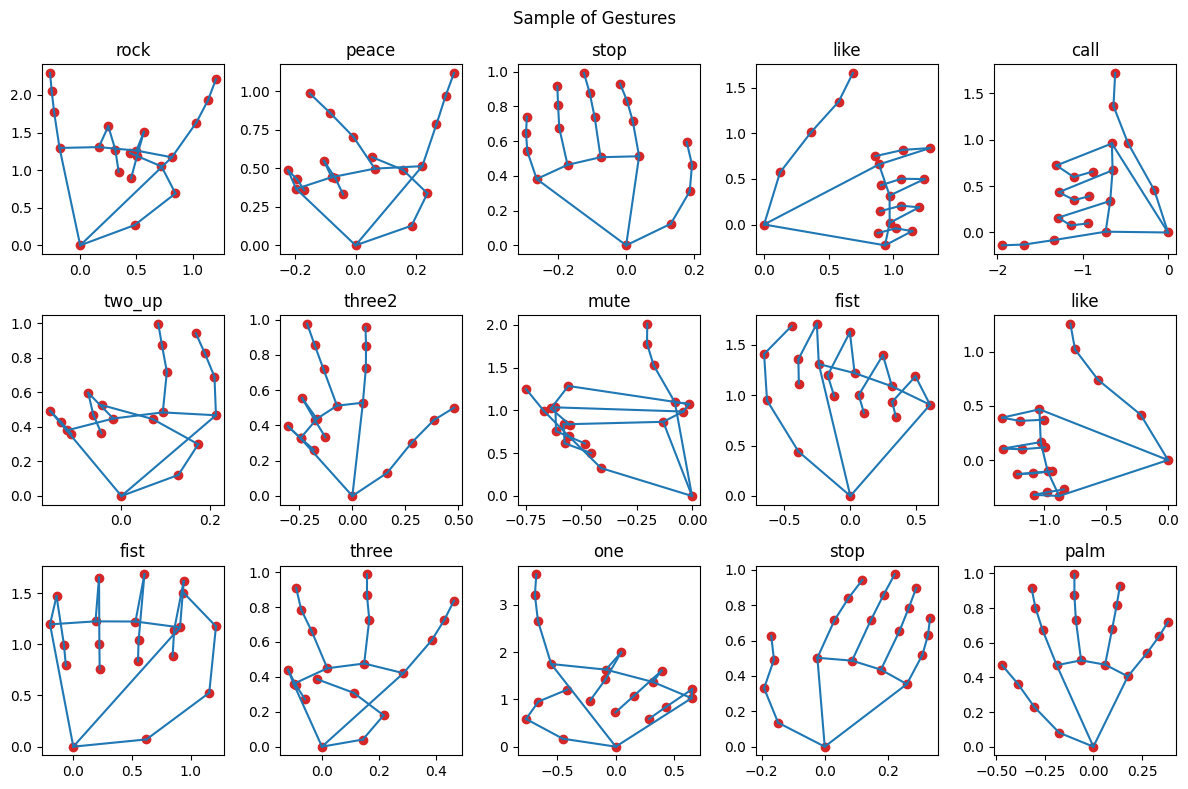

In [13]:
# Visualize a random sample of 15 gestures

sample = preprocessed_data.sample(15, random_state=42)
sample_data = sample.drop(columns=['label'])
sample_labels = sample['label']

plot_gestures(sample_data, sample_labels, rows=3, cols=5, figsize=(12, 8))

## Modeling

### 1. Split Dataset into (Train/Validation/Test)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [15]:
# Train      80%
# Validation 10%
# Test       10%

X = preprocessed_data.drop(columns=['label'])
y = preprocessed_data['label']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=False)

print(f'Training: {X_train.shape[0]}')
print(f'Validation: {X_val.shape[0]}')
print(f'Test: {X_test.shape[0]}')

Training: 20540
Validation: 2567
Test: 2568


### 2. Try Random Forest with Estimators (20 - 50 - 100)

In [16]:
rf_20_model = RandomForestClassifier(n_estimators=20, random_state=42)
rf_50_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_100_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_20_model.fit(X_train, y_train)
rf_50_model.fit(X_train, y_train)
rf_100_model.fit(X_train, y_train)

pred_train_20 = rf_20_model.predict(X_train)
pred_train_50 = rf_50_model.predict(X_train)
pred_train_100 = rf_100_model.predict(X_train)

pred_val_20 = rf_20_model.predict(X_val)
pred_val_50 = rf_50_model.predict(X_val)
pred_val_100 = rf_100_model.predict(X_val)

pred_test_20 = rf_20_model.predict(X_test)
pred_test_50 = rf_50_model.predict(X_test)
pred_test_100 = rf_100_model.predict(X_test)

In [17]:
def accuracy_results(y_train, y_val, y_test, pred_train, pred_val, pred_test):
    print('---------  Accuracy  ---------')
    print(f'Train Accuracy: {accuracy_score(y_train, pred_train)}')
    print(f'Validation Accuracy: {accuracy_score(y_val, pred_val)}')
    print(f'Test Accuracy: {accuracy_score(y_test, pred_test)}')

def precision_results(y_train, y_val, y_test, pred_train, pred_val, pred_test):
    print('\n---------  Precision  --------')
    print(f'Train Precision: {precision_score(y_train, pred_train, average='macro')}')
    print(f'Validation Precision: {precision_score(y_val, pred_val, average='macro')}')
    print(f'Test Precision: {precision_score(y_test, pred_test, average='macro')}')

def recall_results(y_train, y_val, y_test, pred_train, pred_val, pred_test):
    print('\n---------  Recall  ---------')
    print(f'Train Recall: {recall_score(y_train, pred_train, average='macro')}')
    print(f'Validation Recall: {recall_score(y_val, pred_val, average='macro')}')
    print(f'Test Recall: {recall_score(y_test, pred_test, average='macro')}')

def f1_score_results(y_train, y_val, y_test, pred_train, pred_val, pred_test):
    print('\n---------  F1 Score  ---------')
    print(f'Train F1-Score: {f1_score(y_train, pred_train, average='macro')}')
    print(f'Validation F1-Score: {f1_score(y_val, pred_val, average='macro')}')
    print(f'Test F1-Score: {f1_score(y_test, pred_test, average='macro')}')

In [18]:
# Calculate the accuracy, precision, recall, f1_score for our different models
print(f'{rf_20_model.__class__.__name__}: n_estimators = {rf_20_model.n_estimators} | random_state = {rf_20_model.random_state}')
accuracy_results(y_train, y_val, y_test, pred_train_20, pred_val_20, pred_test_20)
precision_results(y_train, y_val, y_test, pred_train_20, pred_val_20, pred_test_20)
recall_results(y_train, y_val, y_test, pred_train_20, pred_val_20, pred_test_20)
f1_score_results(y_train, y_val, y_test, pred_train_20, pred_val_20, pred_test_20)

print('\n===============================================================\n')
print(f'{rf_50_model.__class__.__name__}: n_estimators = {rf_50_model.n_estimators} | random_state = {rf_50_model.random_state}')
accuracy_results(y_train, y_val, y_test, pred_train_50, pred_val_50, pred_test_50)
precision_results(y_train, y_val, y_test, pred_train_50, pred_val_50, pred_test_50)
recall_results(y_train, y_val, y_test, pred_train_50, pred_val_50, pred_test_50)
f1_score_results(y_train, y_val, y_test, pred_train_50, pred_val_50, pred_test_50)

print('\n===============================================================\n')
print(f'{rf_100_model.__class__.__name__}: n_estimators = {rf_100_model.n_estimators} | random_state = {rf_100_model.random_state}')
accuracy_results(y_train, y_val, y_test, pred_train_100, pred_val_100, pred_test_100)
precision_results(y_train, y_val, y_test, pred_train_100, pred_val_100, pred_test_100)
recall_results(y_train, y_val, y_test, pred_train_100, pred_val_100, pred_test_100)
f1_score_results(y_train, y_val, y_test, pred_train_100, pred_val_100, pred_test_100)

RandomForestClassifier: n_estimators = 20 | random_state = 42
---------  Accuracy  ---------
Train Accuracy: 0.9997078870496592
Validation Accuracy: 0.971172574990261
Test Accuracy: 0.971183800623053

---------  Precision  --------
Train Precision: 0.9996996360697281
Validation Precision: 0.9712055106437116
Test Precision: 0.970838333596753

---------  Recall  ---------
Train Recall: 0.9996865725704226
Validation Recall: 0.9712159820286773
Test Recall: 0.97078877625087

---------  F1 Score  ---------
Train F1-Score: 0.9996930192228576
Validation F1-Score: 0.9710997345441518
Test F1-Score: 0.9706250180425897


RandomForestClassifier: n_estimators = 50 | random_state = 42
---------  Accuracy  ---------
Train Accuracy: 0.9999513145082766
Validation Accuracy: 0.9742890533696923
Test Accuracy: 0.9774143302180686

---------  Precision  --------
Train Precision: 0.9999377877317408
Validation Precision: 0.9745861435457768
Test Precision: 0.976481528402902

---------  Recall  ---------
Train Re

In [19]:
# Plot the confussion matrix for our different models
cm = confusion_matrix(y_test, pred_test_20)
disp_20 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_20_model.classes_)

cm = confusion_matrix(y_test, pred_test_50)
disp_50 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_50_model.classes_)

cm = confusion_matrix(y_test, pred_test_100)
disp_100 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_100_model.classes_)

<Figure size 800x600 with 0 Axes>

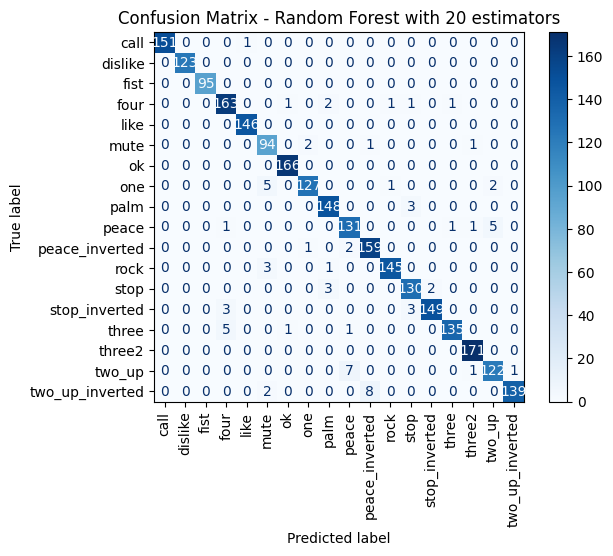

<Figure size 800x600 with 0 Axes>

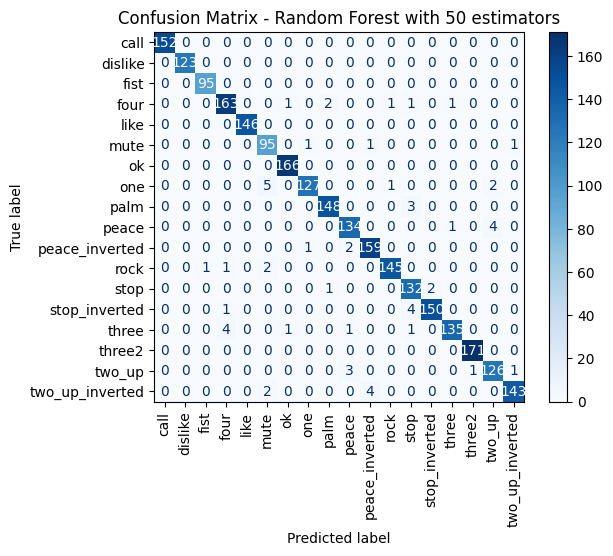

<Figure size 800x600 with 0 Axes>

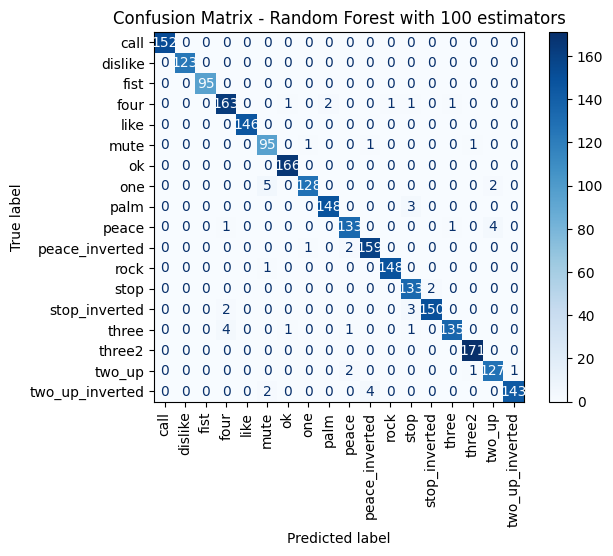

In [20]:
plt.figure(figsize=(8, 6))
disp_20.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - Random Forest with {rf_20_model.n_estimators} estimators")
plt.tick_params(axis='x', rotation=90)
plt.savefig(fname='./Figures/RF20_confussion_matrix.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(8, 6))
disp_50.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - Random Forest with {rf_50_model.n_estimators} estimators")
plt.xticks(rotation=90)
plt.savefig(fname='./Figures/RF50_confussion_matrix.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(8, 6))
disp_100.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - Random Forest with {rf_100_model.n_estimators} estimators")
plt.xticks(rotation=90)
plt.savefig(fname='./Figures/RF100_confussion_matrix.png', dpi=300, bbox_inches='tight')

### 3. Log Random Forest Models

In [21]:
RF_run = start_run(run_name=RandomForestClassifier().__class__.__name__)

# Log the train/validation/test sets
log_dataset(X_train, y_train, name='Training Set', context='train')
log_dataset(X_val, y_val, name='Validation Set', context='val')
log_dataset(X_test, y_test, name='Test Set', context='test')

# Log the Parameters
log_parameters({'RF20': {'n_estimators': rf_20_model.n_estimators,
                         'random_state': rf_20_model.random_state},
                'RF50': {'n_estimators': rf_50_model.n_estimators,
                         'random_state': rf_50_model.random_state},
                'RF100': {'n_estimators': rf_100_model.n_estimators,
                         'random_state': rf_100_model.random_state}})

# Log the models
model_signature_20 = get_model_signature(X_train, rf_20_model)
model_signature_50 = get_model_signature(X_train, rf_50_model)
model_signature_100 = get_model_signature(X_train, rf_100_model)
log_model(rf_20_model, artifact_path='Random Forest - 20', signature=model_signature_20)
log_model(rf_50_model, artifact_path='Random Forest - 50', signature=model_signature_50)
log_model(rf_100_model, artifact_path='Random Forest - 100', signature=model_signature_100)

# Log the confusion matrix of each model
log_artifact('./Figures/RF20_confussion_matrix.png', artifact_path='Random Forest - 20')
log_artifact('./Figures/RF50_confussion_matrix.png', artifact_path='Random Forest - 50')
log_artifact('./Figures/RF100_confussion_matrix.png', artifact_path='Random Forest - 100')

# Evaluate the model
results_20 = evaluate_model(rf_20_model, 'classifier', X_test, y_test)
results_50 = evaluate_model(rf_50_model, 'classifier', X_test, y_test)
results_100 = evaluate_model(rf_100_model, 'classifier', X_test, y_test)

end_run()

2026/02/23 00:19:22 INFO mlflow.models.evaluation.evaluators.classifier: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 18. If this is incorrect, please specify the `label_list` parameter in `evaluator_config`.
2026/02/23 00:19:22 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2026/02/23 00:19:23 WARNING mlflow.models.evaluation.evaluators.shap: Skip logging model explainability insights because it requires all label values to be numeric or boolean.
2026/02/23 00:19:23 INFO mlflow.models.evaluation.evaluators.classifier: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 18. If this is incorrect, please specify the `label_list` parameter in `evaluator_config`.
2026/02/23 00:19:23 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2026/02/23 00:19:24 WARNING mlflow.models.evaluation.evaluators.shap: Skip logging model explainability insights

🏃 View run RandomForestClassifier at: http://127.0.0.1:5000/#/experiments/251002962293238749/runs/9fa016a6076d43cb9ffea30731c89cf0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/251002962293238749


<Figure size 1050x700 with 0 Axes>

In [22]:
# Get the F1_score from MLflow results

print(f'RF_20: {results_20['f1_score']}')
print(f'RF_50: {results_50['f1_score']}')
print(f'RF_100: {results_100['f1_score']}')

RF_20: 0.9712090935543637
RF_50: 0.9774457579141409
RF_100: 0.9793813338296179


### 4. Try SVC

In [23]:
svc_linear = SVC(kernel='linear')
svc_rbf_default = SVC(kernel='rbf', gamma=1.0)
svc_rbf_high_c = SVC(kernel='rbf', gamma=1.0, C=10.0)

svc_linear.fit(X_train, y_train)
svc_rbf_default.fit(X_train, y_train)
svc_rbf_high_c.fit(X_train, y_train)

pred_train_linear = svc_linear.predict(X_train)
pred_train_rbf_default = svc_rbf_default.predict(X_train)
pred_train_rbf_high_c = svc_rbf_high_c.predict(X_train)

pred_val_linear = svc_linear.predict(X_val)
pred_val_rbf_default = svc_rbf_default.predict(X_val)
pred_val_rbf_high_c = svc_rbf_high_c.predict(X_val)

pred_test_linear = svc_linear.predict(X_test)
pred_test_rbf_default = svc_rbf_default.predict(X_test)
pred_test_rbf_high_c = svc_rbf_high_c.predict(X_test)

In [24]:
# Calculate the accuracy, precision, recall, f1_score for our different models
print(f'{svc_linear.__class__.__name__}: kernel = {svc_linear.kernel} | C = {svc_linear.C}')
accuracy_results(y_train, y_val, y_test, pred_train_linear, pred_val_linear, pred_test_linear)
precision_results(y_train, y_val, y_test, pred_train_linear, pred_val_linear, pred_test_linear)
recall_results(y_train, y_val, y_test, pred_train_linear, pred_val_linear, pred_test_linear)
f1_score_results(y_train, y_val, y_test, pred_train_linear, pred_val_linear, pred_test_linear)

print('\n===============================================================\n')
print(f'{svc_rbf_default.__class__.__name__}: kernel = {svc_rbf_default.kernel} | Gamma = {svc_rbf_default.gamma} | C = {svc_rbf_default.C}')
accuracy_results(y_train, y_val, y_test, pred_train_rbf_default, pred_val_rbf_default, pred_test_rbf_default)
precision_results(y_train, y_val, y_test, pred_train_rbf_default, pred_val_rbf_default, pred_test_rbf_default)
recall_results(y_train, y_val, y_test, pred_train_rbf_default, pred_val_rbf_default, pred_test_rbf_default)
f1_score_results(y_train, y_val, y_test, pred_train_rbf_default, pred_val_rbf_default, pred_test_rbf_default)

print('\n===============================================================\n')
print(f'{svc_rbf_high_c.__class__.__name__}: kernel = {svc_rbf_high_c.kernel} | Gamma = {svc_rbf_high_c.gamma} | C = {svc_rbf_high_c.C}')
accuracy_results(y_train, y_val, y_test, pred_train_rbf_high_c, pred_val_rbf_high_c, pred_test_rbf_high_c)
precision_results(y_train, y_val, y_test, pred_train_100, pred_val_rbf_high_c, pred_test_rbf_high_c)
recall_results(y_train, y_val, y_test, pred_train_rbf_high_c, pred_val_rbf_high_c, pred_test_rbf_high_c)
f1_score_results(y_train, y_val, y_test, pred_train_rbf_high_c, pred_val_rbf_high_c, pred_test_rbf_high_c)

SVC: kernel = linear | C = 1.0
---------  Accuracy  ---------
Train Accuracy: 0.8714703018500487
Validation Accuracy: 0.8652123100895988
Test Accuracy: 0.8496884735202492

---------  Precision  --------
Train Precision: 0.8771005778363686
Validation Precision: 0.8673555388691
Test Precision: 0.853692445656662

---------  Recall  ---------
Train Recall: 0.8758321311760384
Validation Recall: 0.865550505985464
Test Recall: 0.8536743168446222

---------  F1 Score  ---------
Train F1-Score: 0.8755875956719076
Validation F1-Score: 0.8649781502796821
Test F1-Score: 0.8521388225676242


SVC: kernel = rbf | Gamma = 1.0 | C = 1.0
---------  Accuracy  ---------
Train Accuracy: 0.9885589094449854
Validation Accuracy: 0.9762368523568368
Test Accuracy: 0.9844236760124611

---------  Precision  --------
Train Precision: 0.9888218635126957
Validation Precision: 0.9764393524072302
Test Precision: 0.9845570026132591

---------  Recall  ---------
Train Recall: 0.9886058748245539
Validation Recall: 0.9757

In [25]:
# Plot the confussion matrix for our different models
cm = confusion_matrix(y_test, pred_test_linear)
disp_linear = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_linear.classes_)

cm = confusion_matrix(y_test, pred_test_rbf_default)
disp_rbf_default = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_rbf_default.classes_)

cm = confusion_matrix(y_test, pred_test_rbf_high_c)
disp_rbf_high_c = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_rbf_high_c.classes_)

<Figure size 800x600 with 0 Axes>

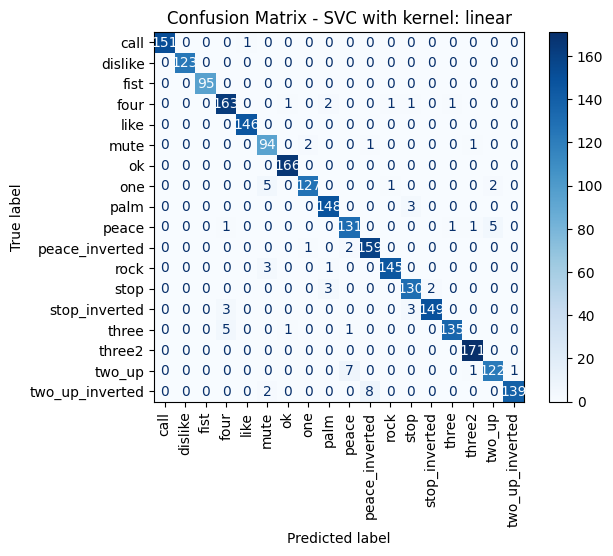

<Figure size 800x600 with 0 Axes>

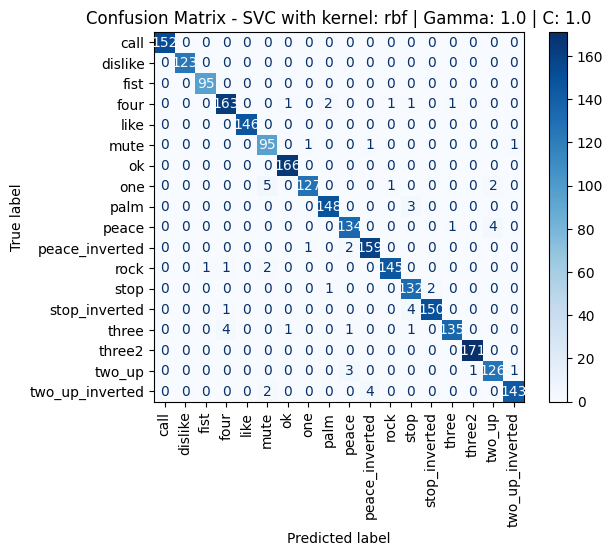

<Figure size 800x600 with 0 Axes>

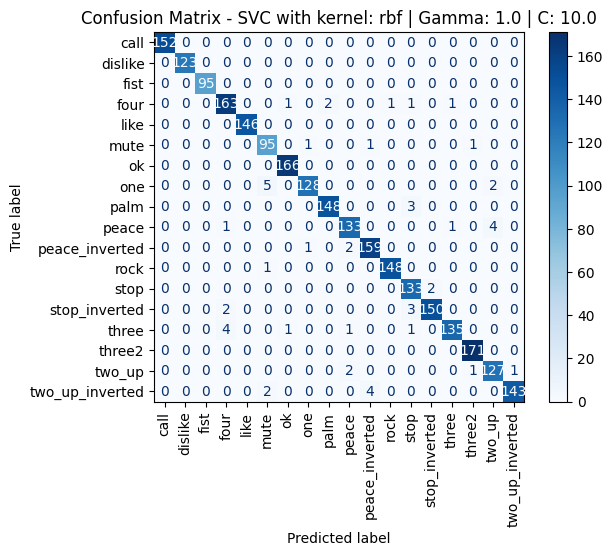

In [26]:
plt.figure(figsize=(8, 6))
disp_20.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - SVC with kernel: {svc_linear.kernel}")
plt.tick_params(axis='x', rotation=90)
plt.savefig(fname='./Figures/SVC_linear_confussion_matrix.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(8, 6))
disp_50.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - SVC with kernel: {svc_rbf_default.kernel} | Gamma: {svc_rbf_default.gamma} | C: {svc_rbf_default.C}")
plt.xticks(rotation=90)
plt.savefig(fname='./Figures/SVC_rbf_default_confussion_matrix.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(8, 6))
disp_100.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - SVC with kernel: {svc_rbf_high_c.kernel} | Gamma: {svc_rbf_high_c.gamma} | C: {svc_rbf_high_c.C}")
plt.xticks(rotation=90)
plt.savefig(fname='./Figures/SVC_rbf_high_c_confussion_matrix.png', dpi=300, bbox_inches='tight')

### 5. Log SVC Models

In [27]:
SCV_run = start_run(run_name=SVC().__class__.__name__)

# Log the train/validation/test sets
log_dataset(X_train, y_train, name='Training Set', context='train')
log_dataset(X_val, y_val, name='Validation Set', context='val')
log_dataset(X_test, y_test, name='Test Set', context='test')

# Log the Parameters
log_parameters({'svc_linear': {'kernel': svc_linear.kernel},
                'svc_rbf_default': {'kernel': svc_rbf_default.kernel,
                                    'gamma': svc_rbf_default.gamma},
                'svc_rbf_high_c': {'kernel': svc_rbf_high_c.kernel,
                                   'gamma': svc_rbf_high_c.gamma,
                                   'C': svc_rbf_high_c.C}})

# Log the models
model_signature_svc_linear = get_model_signature(X_train, svc_linear)
model_signature_svc_rbf_default = get_model_signature(X_train, svc_rbf_default)
model_signature_svc_rbf_high_c = get_model_signature(X_train, svc_rbf_high_c)
log_model(svc_linear, artifact_path='SVC - Linear', signature=model_signature_svc_linear)
log_model(svc_rbf_default, artifact_path='SVC - RBF C1', signature=model_signature_svc_rbf_default)
log_model(svc_rbf_high_c, artifact_path='SVC - RBF C10', signature=model_signature_svc_rbf_high_c)

# Log the confusion matrix of each model
log_artifact('./Figures/SVC_linear_confussion_matrix.png', artifact_path='SVC - Linear')
log_artifact('./Figures/SVC_rbf_default_confussion_matrix.png', artifact_path='SVC - RBF C1')
log_artifact('./Figures/SVC_rbf_high_c_confussion_matrix.png', artifact_path='SVC - RBF C10')

# Evaluate the model
results_linear = evaluate_model(svc_linear, 'classifier', X_test, y_test)
results_rbf_default = evaluate_model(svc_rbf_default, 'classifier', X_test, y_test)
results_rbf_high_c = evaluate_model(svc_rbf_high_c, 'classifier', X_test, y_test)

end_run()

2026/02/23 00:21:18 INFO mlflow.models.evaluation.evaluators.classifier: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 18. If this is incorrect, please specify the `label_list` parameter in `evaluator_config`.
2026/02/23 00:21:18 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2026/02/23 00:21:20 WARNING mlflow.models.evaluation.evaluators.shap: Skip logging model explainability insights because it requires all label values to be numeric or boolean.
2026/02/23 00:21:22 INFO mlflow.models.evaluation.evaluators.classifier: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 18. If this is incorrect, please specify the `label_list` parameter in `evaluator_config`.
2026/02/23 00:21:22 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2026/02/23 00:21:23 WARNING mlflow.models.evaluation.evaluators.shap: Skip logging model explainability insights

🏃 View run SVC at: http://127.0.0.1:5000/#/experiments/251002962293238749/runs/09b105af63ba4f9fa161abedff776341
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/251002962293238749


<Figure size 1050x700 with 0 Axes>

In [28]:
# Get the F1_score from MLflow results

print(f'SVC Linear: {results_linear['f1_score']}')
print(f'SVC RBF C1: {results_rbf_default['f1_score']}')
print(f'SVC RBF C10: {results_rbf_high_c['f1_score']}')

SVC Linear: 0.8482689900830633
SVC RBF C1: 0.9844393694651783
SVC RBF C10: 0.9883274418922906


### 6. Try KNN

In [29]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

pred_train_knn = knn.predict(X_train)
pred_val_knn = knn.predict(X_val)
pred_test_knn = knn.predict(X_test)

In [30]:
# Calculate the accuracy, precision, recall, f1_score for our model
print(f'{knn.__class__.__name__}: n_neighbors = {knn.n_neighbors}')
accuracy_results(y_train, y_val, y_test, pred_train_knn, pred_val_knn, pred_test_knn)
precision_results(y_train, y_val, y_test, pred_train_knn, pred_val_knn, pred_test_knn)
recall_results(y_train, y_val, y_test, pred_train_knn, pred_val_knn, pred_test_knn)
f1_score_results(y_train, y_val, y_test, pred_train_knn, pred_val_knn, pred_test_knn)

KNeighborsClassifier: n_neighbors = 5
---------  Accuracy  ---------
Train Accuracy: 0.9827653359298929
Validation Accuracy: 0.970783015192832
Test Accuracy: 0.9746884735202492

---------  Precision  --------
Train Precision: 0.9828856851961576
Validation Precision: 0.9709514957594979
Test Precision: 0.9743200878559198

---------  Recall  ---------
Train Recall: 0.9826762025719087
Validation Recall: 0.9711784925420327
Test Recall: 0.973874060879165

---------  F1 Score  ---------
Train F1-Score: 0.9827297385606756
Validation F1-Score: 0.9710134290358445
Test F1-Score: 0.9739900741141868


In [31]:
# Plot the confussion matrix for our model
cm = confusion_matrix(y_test, pred_test_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)

<Figure size 800x600 with 0 Axes>

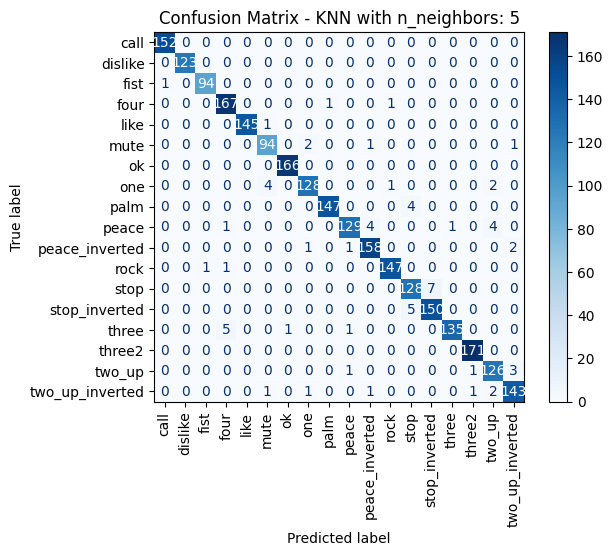

In [32]:
plt.figure(figsize=(8, 6))
disp_knn.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - KNN with n_neighbors: {knn.n_neighbors}")
plt.tick_params(axis='x', rotation=90)
plt.savefig(fname='./Figures/KNN_confussion_matrix.png', dpi=300, bbox_inches='tight')

### 7. Log KNN Model

In [33]:
KNN_run = start_run(run_name=KNeighborsClassifier().__class__.__name__)

# Log the train/validation/test sets
log_dataset(X_train, y_train, name='Training Set', context='train')
log_dataset(X_val, y_val, name='Validation Set', context='val')
log_dataset(X_test, y_test, name='Test Set', context='test')

# Log the Parameters
log_parameters({'n_neighbors': knn.n_neighbors})

# Log the models
model_signature_knn = get_model_signature(X_train, knn)
log_model(knn, artifact_path='KNN', signature=model_signature_knn)

# Log the confusion matrix of each model
log_artifact('./Figures/KNN_confussion_matrix.png', artifact_path='KNN')

# Evaluate the model
results_knn = evaluate_model(knn, 'classifier', X_test, y_test)

end_run()

2026/02/23 00:21:43 INFO mlflow.models.evaluation.evaluators.classifier: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 18. If this is incorrect, please specify the `label_list` parameter in `evaluator_config`.
2026/02/23 00:21:43 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2026/02/23 00:21:44 WARNING mlflow.models.evaluation.evaluators.shap: Skip logging model explainability insights because it requires all label values to be numeric or boolean.


🏃 View run KNeighborsClassifier at: http://127.0.0.1:5000/#/experiments/251002962293238749/runs/412cc20f1618464da710f8a05c030782
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/251002962293238749


<Figure size 1050x700 with 0 Axes>

In [34]:
# Get the F1_score from MLflow results

print(f'KNN: {results_knn['f1_score']}')

KNN: 0.9746821554304631


### 8. Try XGBoost Models

In [35]:
# Encode the labels to integers for the XGBoost model
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

XGB_shallow = XGBClassifier(n_estimators= 100, max_depth= 3, learning_rate= 0.1, random_state=42,
                            use_label_encoder=False, eval_metric='mlogloss')

XGB_deep = XGBClassifier(n_estimators= 100, max_depth= 10, learning_rate= 0.05, random_state=42,
                         use_label_encoder=False, eval_metric='mlogloss')

In [36]:
XGB_shallow.fit(X_train, y_train_encoded)
XGB_deep.fit(X_train, y_train_encoded)

pred_train_shallow = XGB_shallow.predict(X_train)
pred_val_shallow = XGB_shallow.predict(X_val)
pred_test_shallow = XGB_shallow.predict(X_test)

pred_train_deep = XGB_deep.predict(X_train)
pred_val_deep = XGB_deep.predict(X_val)
pred_test_deep = XGB_deep.predict(X_test)

c:\Users\CARNIVAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:200: UserWarning: [00:21:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\CARNIVAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:200: UserWarning: [00:21:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [37]:
# Calculate the accuracy, precision, recall, f1_score for our models
print(f'{XGB_shallow.__class__.__name__}: n_estimators = {XGB_shallow.n_estimators} |  max_depth = {XGB_shallow.max_depth} | learning_rate = {XGB_shallow.learning_rate}')
accuracy_results(y_train_encoded, y_val_encoded, y_test_encoded, pred_train_shallow, pred_val_shallow, pred_test_shallow)
precision_results(y_train_encoded, y_val_encoded, y_test_encoded, pred_train_shallow, pred_val_shallow, pred_test_shallow)
recall_results(y_train_encoded, y_val_encoded, y_test_encoded, pred_train_shallow, pred_val_shallow, pred_test_shallow)
f1_score_results(y_train_encoded, y_val_encoded, y_test_encoded, pred_train_shallow, pred_val_shallow, pred_test_shallow)

print('\n===============================================================\n')
print(f'{XGB_deep.__class__.__name__}: n_estimators = {XGB_deep.n_estimators} |  max_depth = {XGB_deep.max_depth} | learning_rate = {XGB_deep.learning_rate}')
accuracy_results(y_train_encoded, y_val_encoded, y_test_encoded, pred_train_deep, pred_val_deep, pred_test_deep)
precision_results(y_train_encoded, y_val_encoded, y_test_encoded, pred_train_deep, pred_val_deep, pred_test_deep)
recall_results(y_train_encoded, y_val_encoded, y_test_encoded, pred_train_deep, pred_val_deep, pred_test_deep)
f1_score_results(y_train_encoded, y_val_encoded, y_test_encoded, pred_train_deep, pred_val_deep, pred_test_deep)

XGBClassifier: n_estimators = 100 |  max_depth = 3 | learning_rate = 0.1
---------  Accuracy  ---------
Train Accuracy: 0.9864167478091529
Validation Accuracy: 0.9727308141799766
Test Accuracy: 0.969626168224299

---------  Precision  --------
Train Precision: 0.986415247388271
Validation Precision: 0.9721795513097908
Test Precision: 0.9693857190418645

---------  Recall  ---------
Train Recall: 0.9863636644280093
Validation Recall: 0.9723411867965839
Test Recall: 0.969888589701958

---------  F1 Score  ---------
Train F1-Score: 0.9863769382899272
Validation F1-Score: 0.9721697998173668
Test F1-Score: 0.9693970240246086


XGBClassifier: n_estimators = 100 |  max_depth = 10 | learning_rate = 0.05
---------  Accuracy  ---------
Train Accuracy: 0.9987341772151899
Validation Accuracy: 0.975457732761979
Test Accuracy: 0.9762461059190031

---------  Precision  --------
Train Precision: 0.9987271510141473
Validation Precision: 0.9754250920213612
Test Precision: 0.9765204083858965

---------  

In [38]:
# Plot the confussion matrix for our model
cm = confusion_matrix(y_test_encoded, pred_test_shallow)
disp_shallow = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

cm = confusion_matrix(y_test_encoded, pred_test_deep)
disp_deep = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

<Figure size 800x600 with 0 Axes>

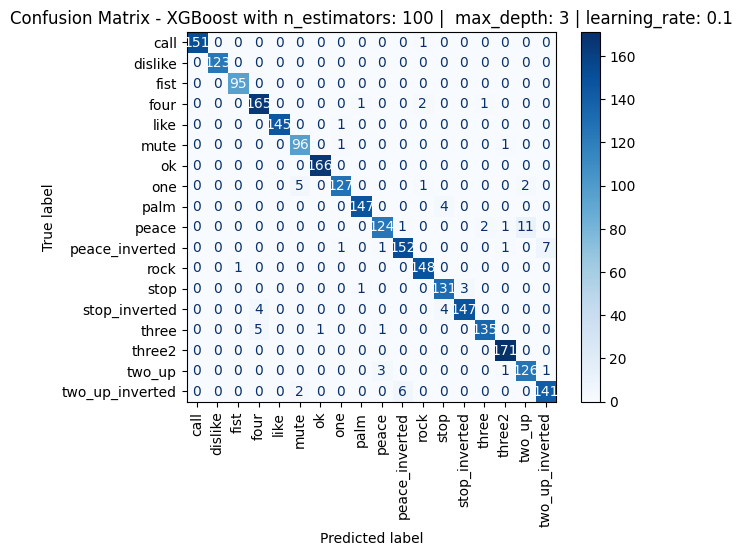

<Figure size 800x600 with 0 Axes>

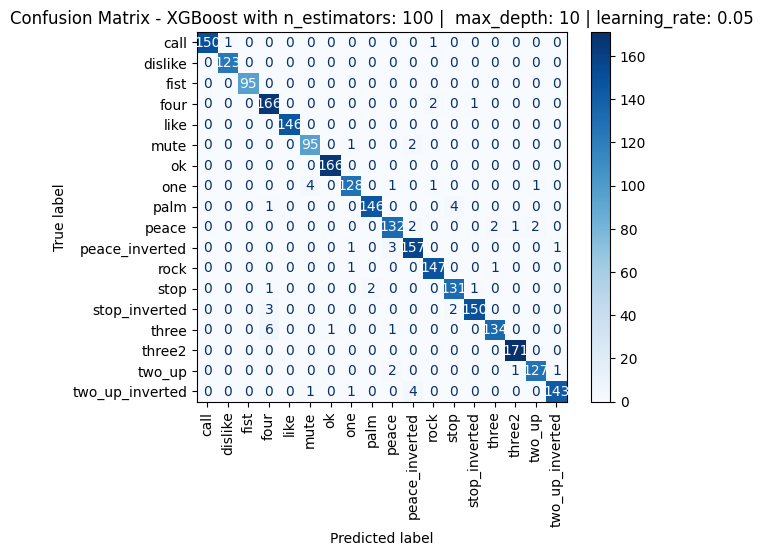

In [39]:
plt.figure(figsize=(8, 6))
disp_shallow.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - XGBoost with n_estimators: {XGB_shallow.n_estimators} |  max_depth: {XGB_shallow.max_depth} | learning_rate: {XGB_shallow.learning_rate}")
plt.tick_params(axis='x', rotation=90)
plt.savefig(fname='./Figures/XGBoost_shallow_confussion_matrix.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(8, 6))
disp_deep.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - XGBoost with n_estimators: {XGB_deep.n_estimators} |  max_depth: {XGB_deep.max_depth} | learning_rate: {XGB_deep.learning_rate}")
plt.tick_params(axis='x', rotation=90)
plt.savefig(fname='./Figures/XGBoost_deep_confussion_matrix.png', dpi=300, bbox_inches='tight')

### 9. Log XGBoost Models

In [40]:
XGB_run = start_run(run_name=XGBClassifier().__class__.__name__)

# Log the train/validation/test sets
log_dataset(X_train, y_train_encoded, name='Training Set', context='train')
log_dataset(X_val, y_val_encoded, name='Validation Set', context='val')
log_dataset(X_test, y_test_encoded, name='Test Set', context='test')

# Log the Parameters
log_parameters({'XGB_shallow': {'n_estimators': XGB_shallow.n_estimators,
                                'max_depth': XGB_shallow.max_depth,
                                'learning_rate': XGB_shallow.learning_rate},
                'XGB_deep': {'n_estimators': XGB_deep.n_estimators,
                                'max_depth': XGB_deep.max_depth,
                                'learning_rate': XGB_deep.learning_rate}})

# Log the models
model_signature_XGB_shallow = get_model_signature(X_train, XGB_shallow)
model_signature_XGB_deep = get_model_signature(X_train,XGB_deep)
log_model(XGB_shallow, artifact_path='XGBoost - Shallow', signature=model_signature_XGB_shallow)
log_model(XGB_deep, artifact_path='XGBoost - Deep', signature=model_signature_XGB_deep)

# Log the confusion matrix of each model
log_artifact('./Figures/XGBoost_shallow_confussion_matrix.png', artifact_path='XGBoost - Shallow')
log_artifact('./Figures/XGBoost_deep_confussion_matrix.png', artifact_path='XGBoost - Deep')

# Evaluate the model
results_shallow = evaluate_model(XGB_shallow, 'classifier', X_test, y_test_encoded)
results_deep = evaluate_model(XGB_deep, 'classifier', X_test, y_test_encoded)

end_run()

c:\Users\CARNIVAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\CARNIVAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent mis

🏃 View run XGBClassifier at: http://127.0.0.1:5000/#/experiments/251002962293238749/runs/6357c2febe2c4de1b35f02e06883ffab
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/251002962293238749


<Figure size 1050x700 with 0 Axes>

In [41]:
# Get the F1_score from MLflow results

print(f'XGBoost shallow: {results_shallow['f1_score']}')
print(f'XGBoost deep: {results_deep['f1_score']}')

XGBoost shallow: 0.9695762460967534
XGBoost deep: 0.9762553948255543


## Summarizing F1 scores for all models 

In [48]:
print(f'{rf_20_model.__class__.__name__}')
print(f'RF20: {f1_score(y_test, pred_test_20, average='macro')}')
print(f'RF50: {f1_score(y_test, pred_test_50, average='macro')}')
print(f'RF100: {f1_score(y_test, pred_test_100, average='macro')}')

print('\n===============================================================\n')
print(f'{svc_linear.__class__.__name__}')
print(f'SVC Linear: {f1_score(y_test, pred_test_linear, average='macro')}')
print(f'SVC RBF Default: {f1_score(y_test, pred_test_rbf_default, average='macro')}')
print(f'SVC RBF High C: {f1_score(y_test, pred_test_rbf_high_c, average='macro')}')

print('\n===============================================================\n')
print(f'{knn.__class__.__name__}')
print(f'KNN: {f1_score(y_test, pred_test_knn, average='macro')}')

print('\n===============================================================\n')
print(f'{XGB_shallow.__class__.__name__}')
print(f'XGBoost Shallow: {f1_score(y_test_encoded, pred_test_shallow, average='macro')}')
print(f'XGBoost Deep: {f1_score(y_test_encoded, pred_test_deep, average='macro')}')

RandomForestClassifier
RF20: 0.9706250180425897
RF50: 0.9767441892633654
RF100: 0.978918150531817


SVC
SVC Linear: 0.8521388225676242
SVC RBF Default: 0.9841170776354369
SVC RBF High C: 0.9879574242797905


KNeighborsClassifier
KNN: 0.9739900741141868


XGBClassifier
XGBoost Shallow: 0.9693970240246086
XGBoost Deep: 0.9762165110526421


In [49]:
# Results from MLflow
print(f'{rf_20_model.__class__.__name__}')
print(f'RF20: {results_20['f1_score']}')
print(f'RF50: {results_50['f1_score']}')
print(f'RF100: {results_100['f1_score']}')

print('\n===============================================================\n')
print(f'{svc_linear.__class__.__name__}')
print(f'SVC Linear: {results_linear['f1_score']}')
print(f'SVC RBF Default: {results_rbf_default['f1_score']}')
print(f'SVC RBF High C: {results_rbf_high_c['f1_score']}')

print('\n===============================================================\n')
print(f'{knn.__class__.__name__}')
print(f'KNN: {results_knn['f1_score']}')

print('\n===============================================================\n')
print(f'{XGB_shallow.__class__.__name__}')
print(f'XGBoost Shallow: {results_shallow['f1_score']}')
print(f'XGBoost Deep: {results_deep['f1_score']}')

RandomForestClassifier
RF20: 0.9712090935543637
RF50: 0.9774457579141409
RF100: 0.9793813338296179


SVC
SVC Linear: 0.8482689900830633
SVC RBF Default: 0.9844393694651783
SVC RBF High C: 0.9883274418922906


KNeighborsClassifier
KNN: 0.9746821554304631


XGBClassifier
XGBoost Shallow: 0.9695762460967534
XGBoost Deep: 0.9762553948255543


From analysis we can conclude that the best model is `svc_rbf_high_c`

## Register best 2 model types in MLflow

In [50]:
# Register the best 2 model types (svc_rbf_high_c --> "Production", rf_100_model --> "Pre-Production")
register_model(SCV_run.info.run_id, artifact_path='SVC - RBF C10', model_name='SVC_RBF_C10')
set_model_description(model_name='SVC_RBF_C10', description='SVC with rbf kernel and C = 10.')
set_model_alias(model_name='SVC_RBF_C10', alias='Production', version='1')
set_model_version_details(model_name='SVC_RBF_C10', version='1',
                          description='This is version 1 of my SVC with rbf kernel and C = 10.')

register_model(RF_run.info.run_id, artifact_path='Random Forest - 100', model_name='RF100')
set_model_description(model_name='RF100', description='Random forest classifier with 100 estimators.')
set_model_alias(model_name='RF100', alias='Pre-Production', version='1')
set_model_version_details(model_name='RF100', version='1',
                          description='This is version 1 of my random forest classifier with 100 estimators.')

Successfully registered model 'SVC_RBF_C10'.
2026/02/23 00:45:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC_RBF_C10, version 1
Created version '1' of model 'SVC_RBF_C10'.
Successfully registered model 'RF100'.
2026/02/23 00:45:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RF100, version 1
Created version '1' of model 'RF100'.


In [43]:
# end_run()

In [44]:
# run = mlflow.last_active_run()
# mlflow.delete_run(run_id=run.info.run_id)

In [45]:
# client = mlflow.MlflowClient()
# client.delete_registered_model('RF100')